# Ad2Play - Evaluation

## Files

 - **data/digital_twins.json** structures both the Siemens and Cisco digital twins. 
 - **data/pattern.json** defines relevant matching terms.
 - **data/csaf.json** stores the converted CSAF documents.
 - **data/cacao.json** holds the generated CACAO playbooks.
 
 - **evaluation.csv** provides the summary for the evaluation.

## Imports

In [456]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle
import plotly.express as px
from matplotlib import rc

## User Definitions

In [457]:
filename = "evaluation.csv"
sns.set(font_scale=1.4)
sentences = 2600
sentences_siemens = 1600
sentences_cisa = 800
sentences_cisco = 100

## Import CSV

In [458]:
df_tasks = pd.read_csv(filename, delimiter=";")
df_tasks.head()

,task_id,csaf_id,playbook_id,twin,source,manual,detected_actions,actual_actions,actions_missing,missing_actions,...,update_step,investigation_step,locating_step,data_operation_step,isolation_step,access_action_step,system_action_step,set_entity_step,traffic_action_step,observe_behavior_step
0,62c3f0af99cf253386589061,62c3f0af99cf253386588bb0,62c44b404466fa24127b09c9,Ad2Play:Mock_Siemens,Siemens ProductCERT,False,5,5,0,NaN,...,3,0,0,0,0,0,1,0,1,0
1,62c3f0af99cf253386588bae,62c3f0af99cf253386588945,62c44b404466fa24127b0858,Ad2Play:Mock_Siemens,Siemens ProductCERT,False,2,2,0,NaN,...,2,0,0,0,0,0,0,0,0,0
2,62c3f0af99cf253386588943,62c3f0af99cf253386588527,62c44b404466fa24127b079d,Ad2Play:Mock_Siemens,Siemens ProductCERT,False,3,3,0,NaN,...,1,0,0,0,0,0,1,0,1,0
3,62c3f0af99cf253386588525,62c3f0af99cf253386588485,62c44b3f4466fa24127b0652,Ad2Play:Mock_Siemens,Siemens ProductCERT,False,4,4,0,NaN,...,2,0,0,0,0,0,2,0,0,0
4,62c3f0af99cf253386588483,62c3f0af99cf2533865882e7,62c44b3f4466fa24127b05f6,Ad2Play:Mock_Siemens,Siemens ProductCERT,False,5,8,3,Update to V4.8 HF6; Deactivate the webserver ...,...,4,0,0,0,0,1,0,0,0,0


## CERT Quality

### Advisories and Actions by CERT

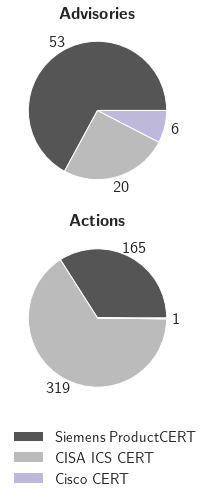

In [485]:
rc('text', usetex=True)
cisco_actions = df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'detected_actions'].sum()
cisa_actions = df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'detected_actions'].sum()
siemens_actions = df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'detected_actions'].sum()
cisco_advisories = df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'source'].count()
cisa_advisories = df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'source'].count()
siemens_advisories = df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'source'].count()

advisories = [siemens_advisories, cisa_advisories, cisco_advisories]
actions = [siemens_actions, cisa_actions, cisco_actions]

mylabels = ["Siemens ProductCERT", "CISA ICS CERT", "Cisco CERT"]
mycolors = ["#555555", "#BBBBBB", "#beb9db"]

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

fig, axs = plt.subplots(2, figsize=(4,7))
axs[0].pie(advisories, autopct = autopct_format(advisories), pctdistance=1.15, colors = mycolors)
axs[0].set_title(r"\textbf{Advisories}")
axs[1].pie(actions, autopct = autopct_format(actions), pctdistance=1.15, colors = mycolors)
axs[1].set_title(r"\textbf{Actions}")

legend = plt.legend(mylabels,bbox_to_anchor=(0.9, 0.1), fontsize=15, 
           bbox_transform=plt.gcf().transFigure, frameon=False)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
plt.show() 

### Categorization of Actions

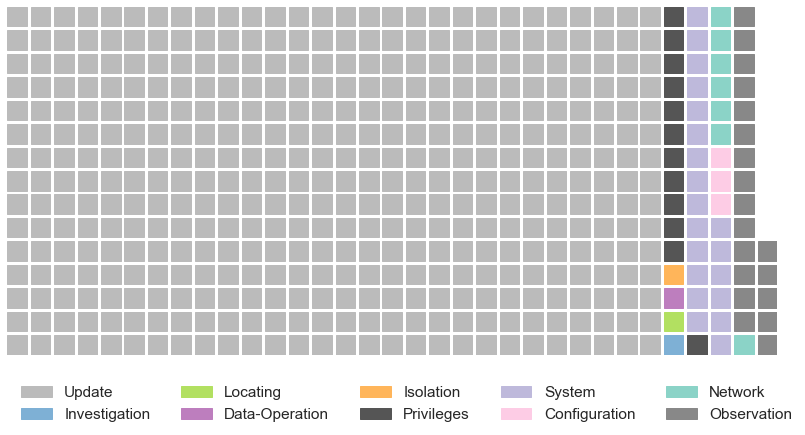

In [491]:
data = {"Update": df_tasks['update_step'].sum(),
         "Investigation": df_tasks['investigation_step'].sum(),
         "Locating": df_tasks['locating_step'].sum(),
         "Data-Operation": df_tasks['data_operation_step'].sum(),
         "Isolation": df_tasks['isolation_step'].sum(),
         "Privileges": df_tasks['access_action_step'].sum(),
         "System": df_tasks['system_action_step'].sum(),
         "Configuration": df_tasks['set_entity_step'].sum(),
         "Network": df_tasks['traffic_action_step'].sum(),
         "Observation": df_tasks['observe_behavior_step'].sum()}

nRows= 15
colors = ["#BBBBBB", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#555555", "#beb9db", "#fdcce5", "#8bd3c7", "#888888"]
fig = plt.figure(
    FigureClass=Waffle,
    rows=nRows,
    colors=colors,
    figsize=(12.5, 12),
    values=data,
    legend={'loc': 'upper left', 'bbox_to_anchor': (0, -0.05), 'ncol': 5, 'framealpha': 0})

plt.show()
rc('text', usetex=False)

## Playbook Quality

### Confusion Matrix for Siemens ProductCERT

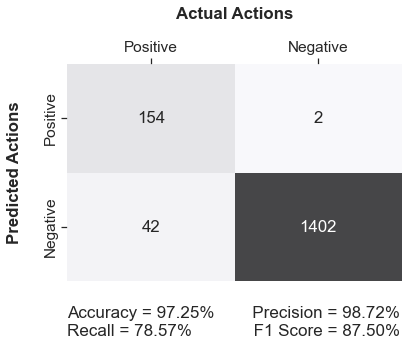

In [473]:
fp = df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'useless_steps'].sum()
fn = df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'actions_missing'].sum()
tp = df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'detected_actions'].sum() - fp - df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'matched_wrong_pattern'].sum() - df_tasks.loc[df_tasks['source'] == "Siemens ProductCERT", 'nlp_error'].sum()
tn = sentences_siemens - fp - fn - tp

accuracy = (tp+tn)/(tp+fn+tn+fp)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1_score = (2 * precision * recall)/(precision + recall)

ax = sns.heatmap([[tp,fp],[fn,tn]],cbar=False, annot=True, cmap='binary', fmt='.4g', alpha=0.7)

stats = "\n\nAccuracy = {:0.2f}%        Precision = {:0.2f}%\nRecall = {:0.2f}%             F1 Score = {:0.2f}%".format(
                accuracy,precision,recall,f1_score)
ax.text(0.0, 2.5, stats,fontsize=17)
ax.set_xlabel('Actual Actions\n', fontdict=dict(weight='bold'))
ax.set_ylabel('Predicted Actions\n', fontdict=dict(weight='bold'));

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()

### Confusion Matrix for Cisco Security Advisory

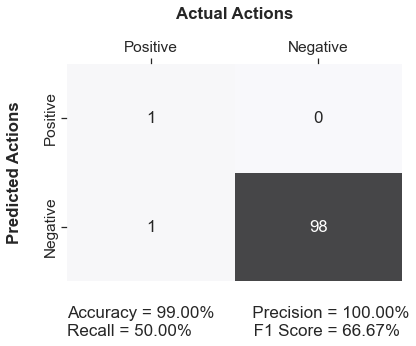

In [487]:
fp = df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'useless_steps'].sum()
fn = df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'actions_missing'].sum()
tp = df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'detected_actions'].sum() - fp - df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'matched_wrong_pattern'].sum() - df_tasks.loc[df_tasks['source'] == "Cisco Security Advisory", 'nlp_error'].sum()
tn = sentences_cisco - fp - fn - tp

accuracy = (tp+tn)/(tp+fn+tn+fp)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1_score = (2 * precision * recall)/(precision + recall)

ax = sns.heatmap([[tp,fp],[fn,tn]],cbar=False, annot=True, cmap='binary', fmt='.4g', alpha=0.7)

stats = "\n\nAccuracy = {:0.2f}%        Precision = {:0.2f}%\nRecall = {:0.2f}%             F1 Score = {:0.2f}%".format(
                accuracy,precision,recall,f1_score)
ax.text(0.0, 2.5, stats,fontsize=17)
ax.set_xlabel('Actual Actions\n', fontdict=dict(weight='bold'))
ax.set_ylabel('Predicted Actions\n', fontdict=dict(weight='bold'));

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()

### Confusion Matrix for CISA ICS CERT

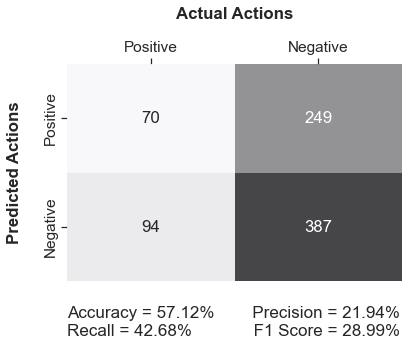

In [488]:
fp = df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'useless_steps'].sum()
fn = df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'actions_missing'].sum()
tp = df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'detected_actions'].sum() - fp - df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'matched_wrong_pattern'].sum() - df_tasks.loc[df_tasks['source'] == "CISA ICS CERT", 'nlp_error'].sum()
tn = sentences_cisa - fp - fn - tp

accuracy = (tp+tn)/(tp+fn+tn+fp)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1_score = (2 * precision * recall)/(precision + recall)

ax = sns.heatmap([[tp,fp],[fn,tn]],cbar=False, annot=True, cmap='binary', fmt='.4g', alpha=0.7)

stats = "\n\nAccuracy = {:0.2f}%        Precision = {:0.2f}%\nRecall = {:0.2f}%             F1 Score = {:0.2f}%".format(
                accuracy,precision,recall,f1_score)
ax.text(0.0, 2.5, stats,fontsize=17)
ax.set_xlabel('Actual Actions\n', fontdict=dict(weight='bold'))
ax.set_ylabel('Predicted Actions\n', fontdict=dict(weight='bold'));

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()

### Confusion Matrix CERT Summary

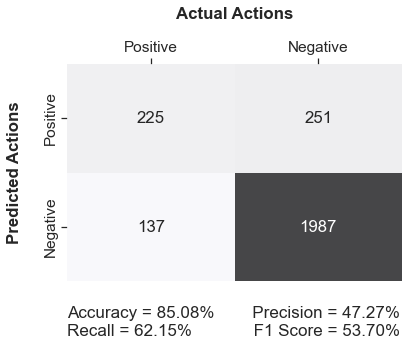

In [489]:
fp = df_tasks['useless_steps'].sum()
fn = df_tasks['actions_missing'].sum()
tp = df_tasks['detected_actions'].sum() - fp - df_tasks['matched_wrong_pattern'].sum() - df_tasks['nlp_error'].sum()
tn = sentences - fp - fn - tp

accuracy = (tp+tn)/(tp+fn+tn+fp)*100
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f1_score = (2 * precision * recall)/(precision + recall)

ax = sns.heatmap([[tp,fp],[fn,tn]],cbar=False, annot=True, cmap='binary', fmt='.4g', alpha=0.7)

stats = "\n\nAccuracy = {:0.2f}%        Precision = {:0.2f}%\nRecall = {:0.2f}%             F1 Score = {:0.2f}%".format(
                accuracy,precision,recall,f1_score)
ax.text(0.0, 2.5, stats,fontsize=17)
ax.set_xlabel('Actual Actions\n', fontdict=dict(weight='bold'))
ax.set_ylabel('Predicted Actions\n', fontdict=dict(weight='bold'));

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()